In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    RobustScaler,
    PowerTransformer,
)
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

plt.style.use("fivethirtyeight")

In [2]:
dataset = pd.read_csv("./customer_data.csv")
dataset.columns

Index(['id', 'age', 'gender', 'income', 'education', 'region',
       'loyalty_status', 'purchase_frequency', 'purchase_amount',
       'product_category', 'promotion_usage', 'satisfaction_score'],
      dtype='object')

In [3]:
loyalty_status = dataset["loyalty_status"]
dataset.drop("loyalty_status", axis=1, inplace=True)
loyalty_status.unique()

array(['Gold', 'Regular', 'Silver'], dtype=object)

In [4]:
dataset.describe()

,id,age,income,purchase_amount,promotion_usage,satisfaction_score
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,30.003260,27516.269880,9634.790840,0.300800,5.009650
std,28867.657797,4.480535,12996.782587,4799.339449,0.458608,1.038714
min,1.000000,12.000000,5000.000000,1118.000000,0.000000,0.000000
25%,25000.750000,27.000000,16271.750000,5583.000000,0.000000,4.000000
50%,50000.500000,30.000000,27584.500000,9452.000000,0.000000,5.000000
75%,75000.250000,33.000000,38747.250000,13350.000000,1.000000,6.000000
max,100000.000000,49.000000,50000.000000,26204.000000,1.000000,10.000000


In [5]:
print("Kurtosis Results: \n", dataset.select_dtypes(include="number").kurtosis())

Kurtosis Results: 
 id                   -1.200000
age                  -0.007840
income               -1.200661
purchase_amount      -0.864059
promotion_usage      -1.245328
satisfaction_score   -0.001749
dtype: float64


In [6]:
print("Skew Results: \n", dataset.select_dtypes(include="number").kurtosis())

Skew Results: 
 id                   -1.200000
age                  -0.007840
income               -1.200661
purchase_amount      -0.864059
promotion_usage      -1.245328
satisfaction_score   -0.001749
dtype: float64


In [7]:
categorical_cols = dataset.select_dtypes(include="object").columns
categorical_cols

Index(['gender', 'education', 'region', 'purchase_frequency',
       'product_category'],
      dtype='object')

## Visualizing the Dataset

In [8]:
def plot_relational_graph(x, y):
    """
    Creates a scatter plot visualizing the relationship between two variables in a dataset.

    Args:
        x (str): The name of the first variable (x-axis) in the dataset.
        y (str): The name of the second variable (y-axis) in the dataset.

    Returns:
        None. (The function creates a plot and does not return a value.)
    """
    plt.scatter(dataset[x], dataset[y])
    plt.title(f"Scatter Plot of {y.title()} against {x.title()}")
    plt.xlabel(x.title())
    plt.ylabel(y.title())
    plt.xlim(-np.min(dataset[x]) * 1.5, np.max(dataset[x]) * 1.5)

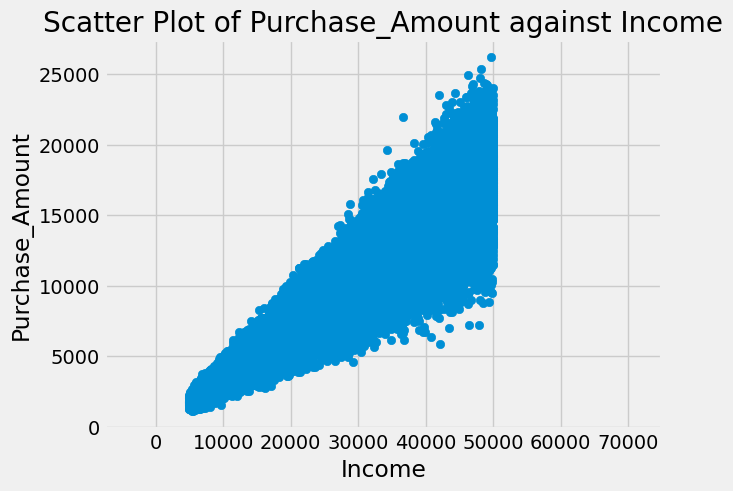

In [9]:
plot_relational_graph("income", "purchase_amount")

In [10]:
def plot_histogram(x):
    """
    Creates a histogram visualizing the distribution of a variable in a dataset.

    Args:
        x (str): The name of the variable to create the histogram for (x-axis).

    Returns:
        None. (The function creates a plot and does not return a value.)
    """
    plt.hist(dataset[x])
    plt.title(f"Histogram of {x.title()}")
    plt.xlabel(x.title())
    plt.ylabel("Frequency")
    plt.legend(["Frequency"])

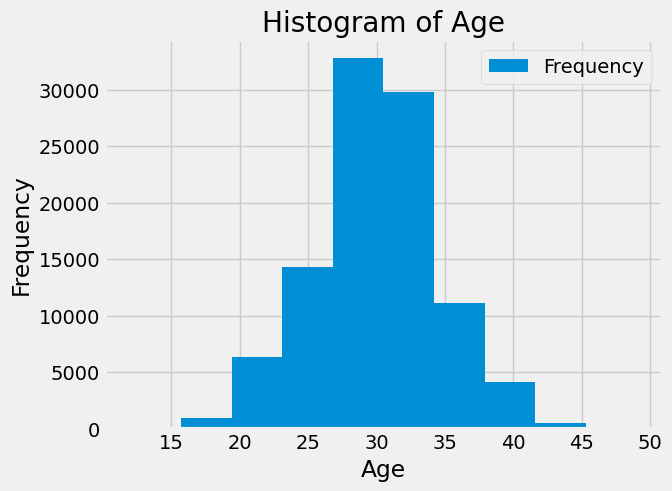

In [11]:
plot_histogram("age")

In [12]:
def plot_bar_chart():
    """
    Creates a bar chart visualizing the distribution of customer loyalty statuses.

    Args:
        loyalty_status (pd.Series): A pandas Series containing customer loyalty statuses.

    Returns:
        None. (The function creates a plot and does not return a value.)
    """
    loyalty_value_counts = loyalty_status.value_counts().to_dict()
    plt.bar(
        loyalty_value_counts.keys(),
        loyalty_value_counts.values(),
        color=["green", "silver", "gold"],
        label=True,
    )
    plt.title("Bar Chart of Customer Loyalty Status")
    plt.xlabel("Loyalty Status")
    plt.ylabel("Frequency")

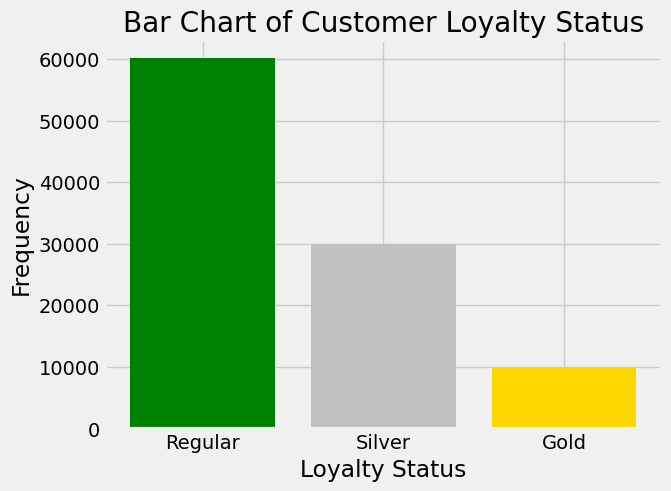

In [13]:
plot_bar_chart()

In [14]:
def plot_heatmap():
    num_cols = dataset.select_dtypes(["number"])
    sns.heatmap(num_cols.corr())
    plt.title("Heat Map of the Dataset")

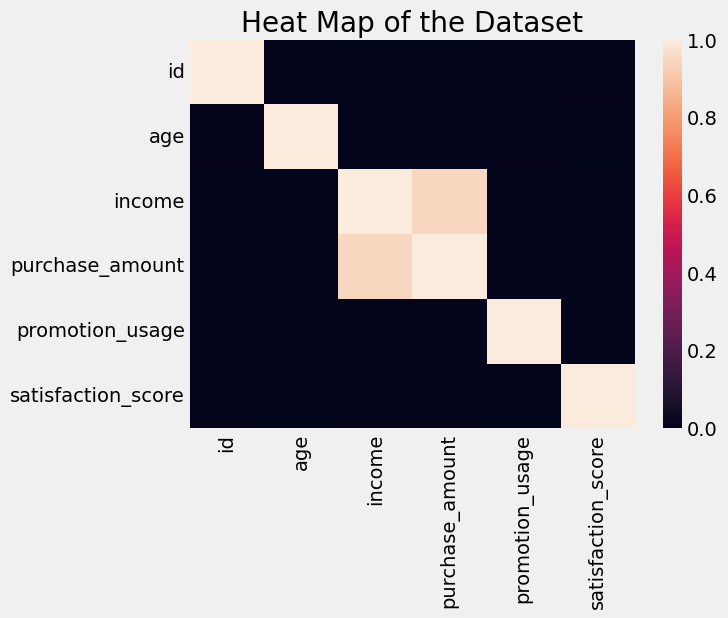

In [15]:
plot_heatmap()

## Encoding Categorical Values
Label Encoding gives a sense of hierachy to category values, which is what we hope to achieve with those values

In [16]:
label_encoded_features = [
    "education",
    "purchase_frequency",
    "gender",
    "region",
    "product_category",
]

# Label Encoding
for feature in label_encoded_features:
    label_encoder = LabelEncoder()
    dataset[f"{feature}_label"] = label_encoder.fit_transform(dataset[feature])

In [17]:
dataset.columns

Index(['id', 'age', 'gender', 'income', 'education', 'region',
       'purchase_frequency', 'purchase_amount', 'product_category',
       'promotion_usage', 'satisfaction_score', 'education_label',
       'purchase_frequency_label', 'gender_label', 'region_label',
       'product_category_label'],
      dtype='object')

In [18]:
columns = ["age", "income", "purchase_amount", "promotion_usage", "satisfaction_score"]
label_encoded_columns = [f"{feature}_label" for feature in label_encoded_features]

training_columns = columns + label_encoded_columns
features = dataset[training_columns]

In [19]:
training_columns

['age',
 'income',
 'purchase_amount',
 'promotion_usage',
 'satisfaction_score',
 'education_label',
 'purchase_frequency_label',
 'gender_label',
 'region_label',
 'product_category_label']

## Normalize features

In [20]:
# RobustScaler removes the median and scales the data according to the quantile range
# and is more robust to outliers
scaler = RobustScaler()
scaled_features = scaler.fit_transform(features)

In [21]:
training_columns

['age',
 'income',
 'purchase_amount',
 'promotion_usage',
 'satisfaction_score',
 'education_label',
 'purchase_frequency_label',
 'gender_label',
 'region_label',
 'product_category_label']

## K-Means fitting and Clustering

### Elbow method

In [22]:
def elbow_cluster_fit():
    kmeans_kwargs = {
        "init": "random",
        "n_init": "auto",
        "max_iter": 300,
        "random_state": 42,
    }

    # A list holds the SSE values for each k
    k_range = range(1, 10)
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
    plt.style.use("fivethirtyeight")
    plt.title("k-Means - Elbow Method")
    plt.plot(k_range, sse)
    plt.xticks(k_range)
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()

    # return sse

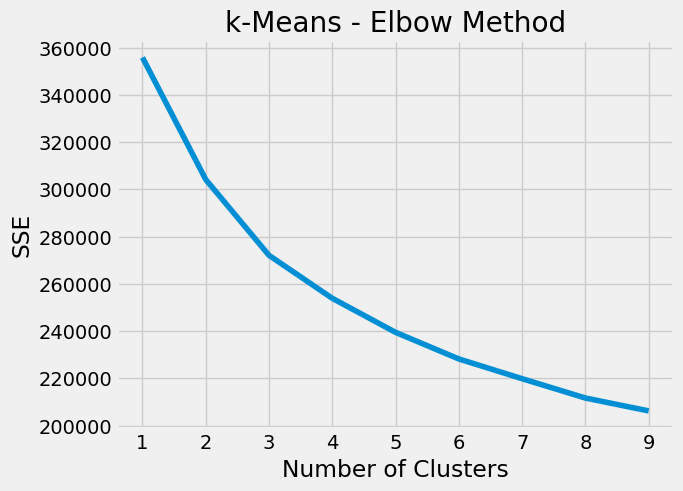

In [23]:
elbow_cluster_fit()

## k-means Silhouette Method

In [109]:
def silhouette_cluster_fit():
    kmeans_kwargs = {
        "init": "random",
        "n_init": "auto",
        "max_iter": 300,
        "random_state": 42,
    }
    # A list holds the silhouette coefficients for each k
    silhouette_coefficients = []
    k_range = range(2, 11)

    # Notice you start at 2 clusters for silhouette coefficient
    for k in k_range:
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        print("Calculating silheouette_score for run: ", k)
        score = silhouette_score(scaled_features, kmeans.labels_, n_jobs=-1)
        silhouette_coefficients.append(score)

    plt.style.use("fivethirtyeight")
    plt.title("k-Means - Elbow Method")
    plt.plot(k_range, silhouette_coefficients)
    plt.xticks(k_range)
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()

    # return silhouette_coefficients

In [ ]:
silhouette_cluster_fit()

Calculating silheouette_score for run:  2


### Performing Clustering

In [33]:
def create_cluster_model(k, X):
    kmeans = KMeans(init="random", n_clusters=k, random_state=50)
    kmeans.fit(X)
    return kmeans

In [55]:
cluster_train, cluster_test = train_test_split(scaled_features,test_size=0.01)
kmeans = create_cluster_model(2, cluster_train)

In [56]:
labels_pred = kmeans.predict(cluster_test)

In [100]:
def plot_clusters(kmeans, x_feature=0, y_feature=1):
    """
    x_feature: The index of the feature that should be plotted on the x-axis
    y_feature: The index of the feature that should be plotted on the y-axis
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=False)
    fig.suptitle(f"k-means Clustering of Customer Purchase Data", fontsize=16)
    fte_colors = {
        0: "#008fd5",
        1: "#fc4f30",
        2: "#FFBB00",
        3: "#303030",
        4: "#EE82EE",
        5: "#007F0E",
        6: "#909000",
        7: "#101214",
        8: "#101A11",
        9: "#10C224",
    }
    x_name, y_name = features.columns[x_feature], features.columns[y_feature]
    
    # Known data
    km_colors = [fte_colors[label] for label in kmeans.labels_]
    ax1.scatter(
        cluster_train[:, x_feature], cluster_train[:, y_feature], c=km_colors
    )
    ax1.set_title(f"Train-set\nMin. SSE={kmeans.inertia_:.2f}\nNo. Iters={kmeans.n_iter_}", fontdict={"fontsize": 12})
    
    # Unknown data
    db_colors = [fte_colors[label] for label in labels_pred]
    ax2.scatter(cluster_test[:, x_feature], cluster_test[:, y_feature], c=db_colors)
    ax2.set_title(f"Test-set (Predicted Values)", fontdict={"fontsize": 12}) 

    fig.supxlabel(x_name)
    ax1.set_ylabel(y_name)
    plt.subplots_adjust(top=0.825)
    plt.show()

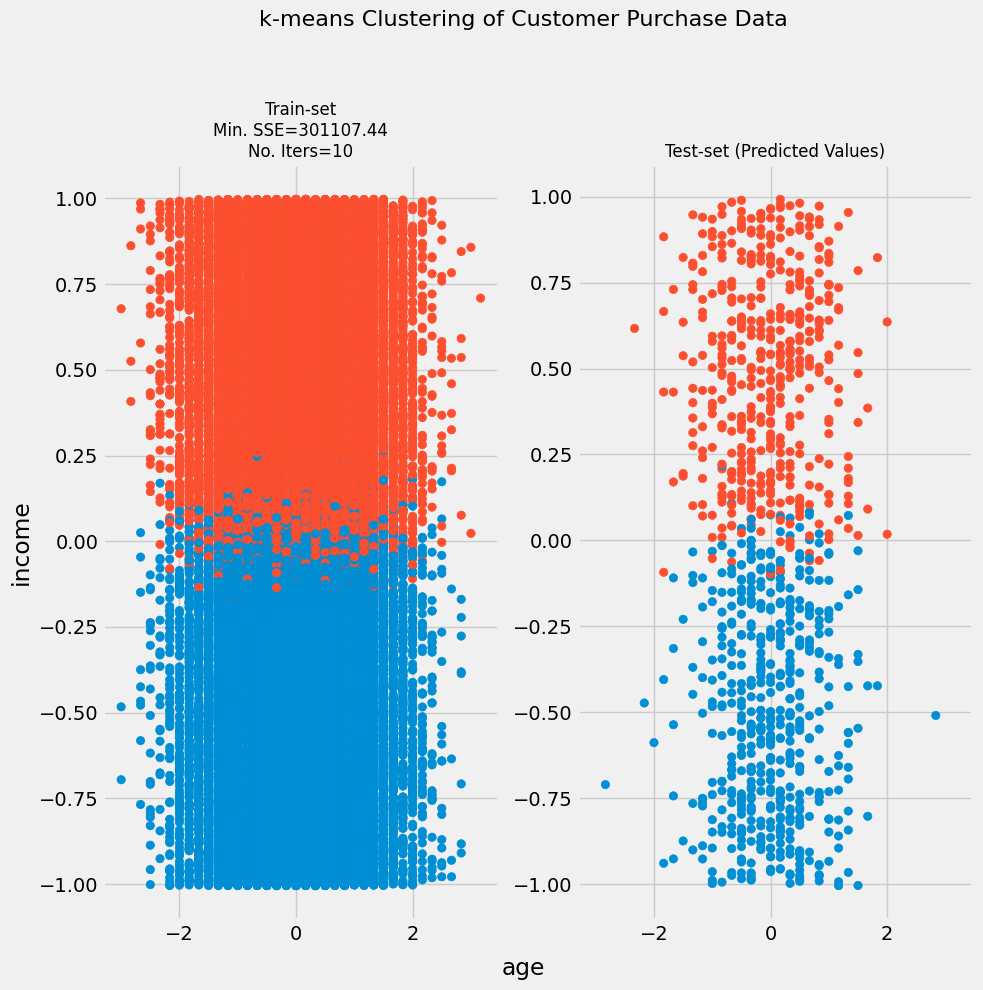

In [101]:
plot_clusters(kmeans, 0, 1)

## Line Fitting

In [105]:
def create_linear_model(X, y):
    # Initialize model
    gradient_boosting = GradientBoostingRegressor(n_estimators=100)
    gradient_boosting.fit(X, y.ravel())
    return gradient_boosting

In [106]:
X = scaler.fit_transform(features.drop(columns=["income"]))
y = scaler.fit_transform(features[["income"]])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
linear_model = create_linear_model(X_train, y_train)

In [107]:
y_pred = linear_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Gradient Boosting - MSE: {mse}, R2 Score: {r2}")

Gradient Boosting - MSE: 0.027235738404334135, R2 Score: 0.9182670649082801


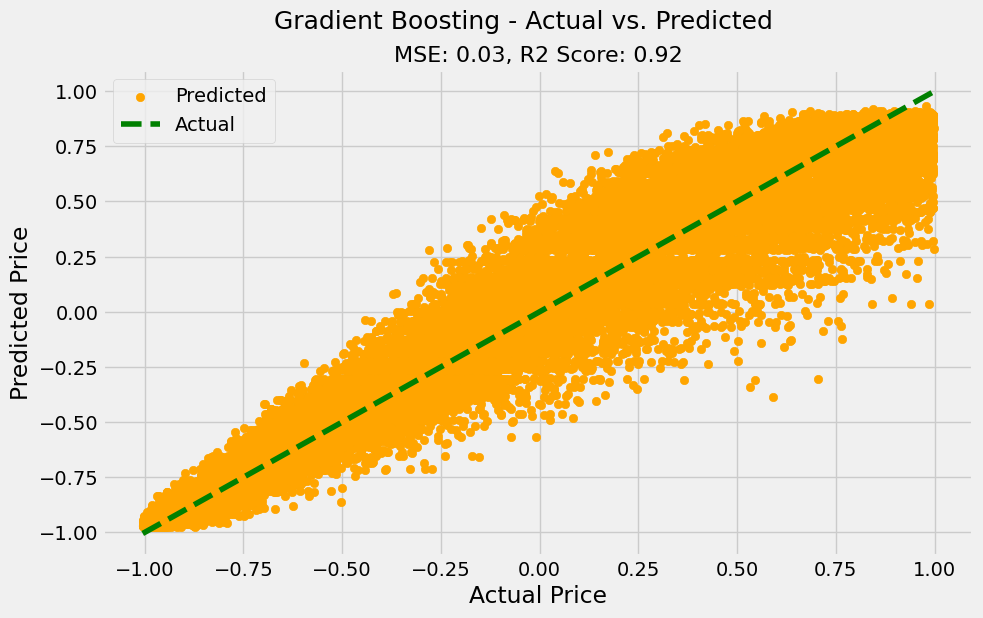

In [108]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color="orange", label="Predicted")
plt.plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color="green",
    linestyle="--",
    label="Actual",
)
plt.title(f"MSE: {mse:.2f}, R2 Score: {r2:.2f}", fontsize=16)
plt.suptitle(f"Gradient Boosting - Actual vs. Predicted", fontsize=18)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.legend()